## Photometry

In this notebook, you will learn to count photons from a target source and determine its magnitude.

Requisites:
* a working Python 3.x environment, with **Astropy** (4.0), **Matplotlib** (3.1), and **NumPy** (1.18) installed;
* a ```utils.py``` file with useful functions;
* a (set of) reduced science frame(s) (e.g. ```sci_2015/Reduced-001(NNN).fits```).

### A bullseye on our star

Let's start from our reduced science frame, and highlight the pixel with the highest ADU value (we are lucky that it is on our star!):

In [3]:
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import *


sci = fits.open('sci_2015/Reduced-001.fits')[0]
x_max, y_max = extrema(sci.data)

plot_img_medrange(sci.data)
plt.scatter(x_max, y_max)
plt.show()

<Figure size 1200x800 with 2 Axes>

It's better to consider just a limited region around the star:

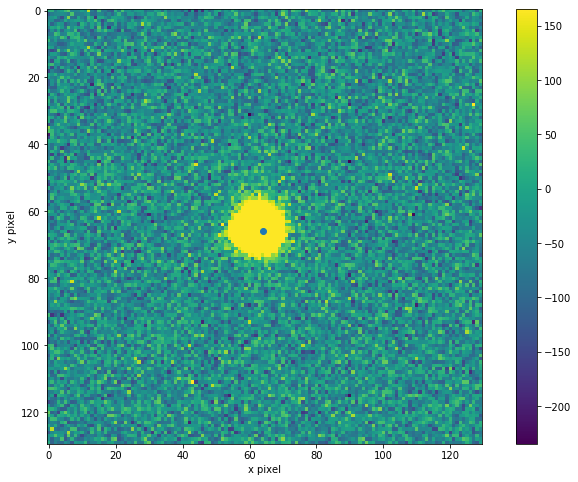

In [4]:
import numpy as np

reg = np.s_[250:380,400:530]
sub_img = sci.data[reg]
x_max, y_max = extrema(sub_img)

plot_img_medrange(sub_img)
plt.scatter(x_max, y_max)
plt.show()

The simplest way to cut out our source is to draw a **square mask** around it. We can use ```ogrid``` to obtain row and column indexes re-centered on the red spot:

In [5]:
shape = sub_img.shape
rows, cols = np.ogrid[-y_max:shape[0]-y_max, -x_max:shape[1]-x_max]
print(rows)
print(cols)

[[-66]
 [-65]
 [-64]
 [-63]
 [-62]
 [-61]
 [-60]
 [-59]
 [-58]
 [-57]
 [-56]
 [-55]
 [-54]
 [-53]
 [-52]
 [-51]
 [-50]
 [-49]
 [-48]
 [-47]
 [-46]
 [-45]
 [-44]
 [-43]
 [-42]
 [-41]
 [-40]
 [-39]
 [-38]
 [-37]
 [-36]
 [-35]
 [-34]
 [-33]
 [-32]
 [-31]
 [-30]
 [-29]
 [-28]
 [-27]
 [-26]
 [-25]
 [-24]
 [-23]
 [-22]
 [-21]
 [-20]
 [-19]
 [-18]
 [-17]
 [-16]
 [-15]
 [-14]
 [-13]
 [-12]
 [-11]
 [-10]
 [ -9]
 [ -8]
 [ -7]
 [ -6]
 [ -5]
 [ -4]
 [ -3]
 [ -2]
 [ -1]
 [  0]
 [  1]
 [  2]
 [  3]
 [  4]
 [  5]
 [  6]
 [  7]
 [  8]
 [  9]
 [ 10]
 [ 11]
 [ 12]
 [ 13]
 [ 14]
 [ 15]
 [ 16]
 [ 17]
 [ 18]
 [ 19]
 [ 20]
 [ 21]
 [ 22]
 [ 23]
 [ 24]
 [ 25]
 [ 26]
 [ 27]
 [ 28]
 [ 29]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 34]
 [ 35]
 [ 36]
 [ 37]
 [ 38]
 [ 39]
 [ 40]
 [ 41]
 [ 42]
 [ 43]
 [ 44]
 [ 45]
 [ 46]
 [ 47]
 [ 48]
 [ 49]
 [ 50]
 [ 51]
 [ 52]
 [ 53]
 [ 54]
 [ 55]
 [ 56]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 61]
 [ 62]
 [ 63]]
[[-64 -63 -62 -61 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 -50 -49 -48 -47
  -46 -45 -44 -

The square mask is then defined by selecting the rows and columns whose re-centered indexes do no exceed some given threshold:

In [6]:
thr=10
mask = np.logical_and(np.abs(rows)<thr, np.abs(cols)<thr)
print(mask)
print(np.where(mask==True))

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
(array([57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 57,
       57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58,
       58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59,
       59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60,
       60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61,
       61, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62,
       62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63,
       63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64,
       64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65,
       65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 6

One way to apply the mask is to selectively set to NaN all the pixels of the image where the mask is ```False``` or ```True```. Before doing that, we must create copies of the image, otherwise the information in the masked pixels will be lost:

int64


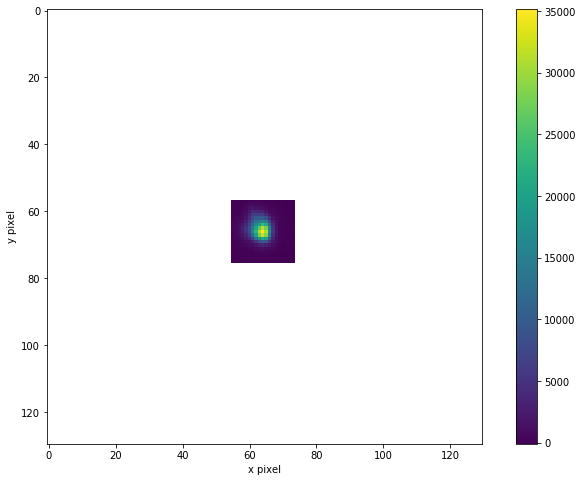

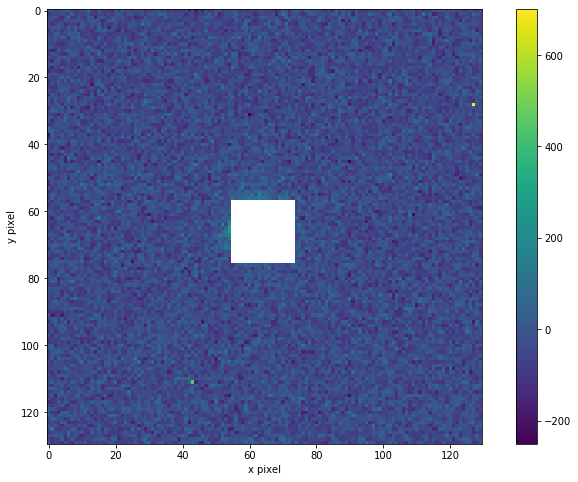

In [7]:
inside = np.copy(sub_img)
outside = np.copy(sub_img)
ciao = np.ones(10, dtype=int)
print(ciao.dtype)
inside[~mask] = np.nan
outside[mask] = np.nan

plot_img(inside)
plot_img(outside)
plt.show()

### There's something in the background

The ```inside``` and ```outside``` cut-outs reveal a very different distribution of ADU values. The ```outside``` readings, in particular, are more-or-less gaussianly distributed around a central value:

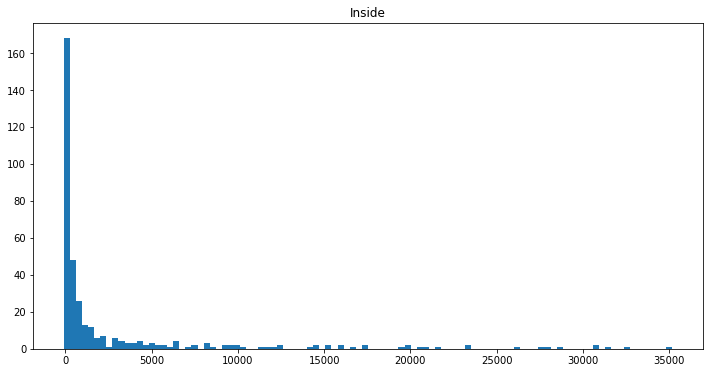

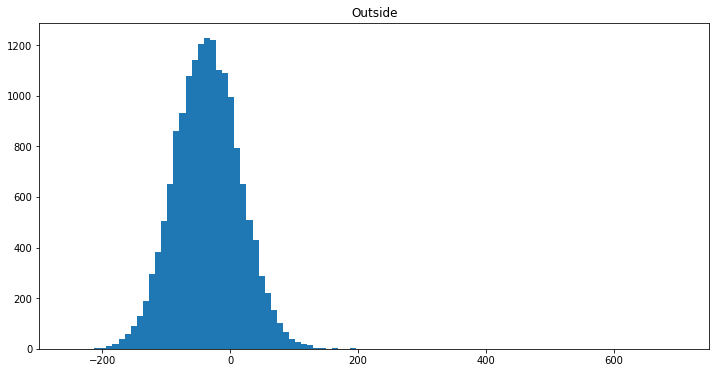

In [8]:
plt.figure(figsize=(12,6))
plt.hist(np.ravel(inside[~np.isnan(inside)]), bins=100)
plt.title('Inside')

plt.figure(figsize=(12,6))
plt.hist(np.ravel(outside[~np.isnan(outside)]), bins=100)
plt.title('Outside')

plt.show()

We take the mean of the distribution as an estimate of the **background**, and subtract it from the ```inside``` cut-out. Note that this value is negative, as we previously over-subtracted the bias (see ```reduction.ipynb```). To compute the mean and the standard deviation, we use ```nanmean``` and ```nanstd```, to properly reject NaN values in the arrays:

In [9]:
outside_mean = np.nanmean(outside)
outside_std = np.nanstd(outside)

gain = 0.6  # ph/ADU
bkg = outside_mean*gain
bkg_noise = outside_std*gain
print("Background: %2.1f+/-%2.1f ph" % (bkg, bkg_noise))

Background: -21.3+/-30.7 ph


### Counting photons

The flux image is obtained by subtracting the background from the ```inside``` cut–out and removing the region with NaN values. We also convert it into photons:

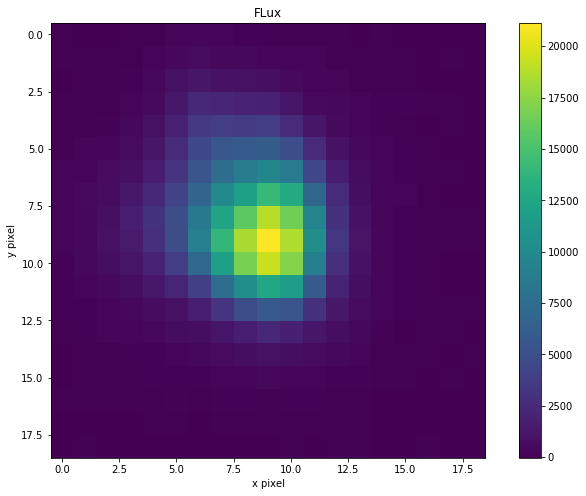

Peak: 2.11e+04, median: 2.17e+02


In [10]:
inside_bkgsub = inside-outside_mean

inside_nonan = inside_bkgsub[~np.isnan(inside_bkgsub)]
size = int(np.sqrt(len(inside_nonan)))
flux = inside_nonan.reshape(size, size)*gain

plot_img(flux)
plt.title('FLux')
plt.show()
print("Peak: %2.2e, median: %2.2e" % (np.max(flux), np.median(flux)))

The error image is obtained as the root sum squared of the photon shot noise, the RON (see ```reduction.ipynb```), and the background noise:

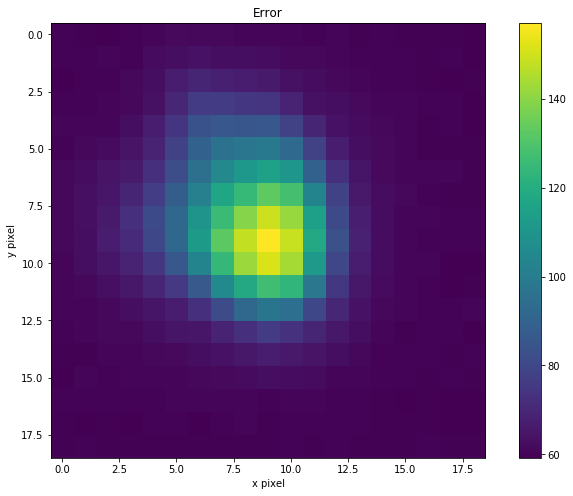

Peak: 1.57e+02 ph, median: 6.13e+01 ph


In [11]:
ron = 28.8  # ph
error = np.sqrt(flux + 2*ron**2 + 2*bkg_noise**2)

plot_img(error)
plt.title('Error')
plt.show()
print("Peak: %2.2e ph, median: %2.2e ph" % (np.max(error), np.median(error)))

The factor of 2 for the RON and background noise is actually too pessimistic. Normally, these noise contributions must be counted twice because the relative signal is first added to and then subtracted from the signal of our target. But in our case, we estimate both the RON and the background noise on a larger area (a 50x50 subimage in 7 bias frames for the RON – see ```reduction.ipynb``` – and the ```outside``` region for the background noise). We can therefore rescale the contributions due to subtraction by the ratio between the number of pixels in the ```inside``` region and the number of pixels where the two source of noise were estimated:

In [15]:
ron_subfact = np.sum(mask)/(50*50)
bkg_subfact = np.sum(mask)/np.sum(~mask)
print("Subtraction factors: %2.2f, median: %2.2f" % (ron_subfact, bkg_subfact))

Subtraction factors: 0.14, median: 0.02


So, a more accurate propagation of the error gives:

In [16]:
error = np.sqrt(flux + (1+ron_subfact)*ron**2 + (1+bkg_subfact)*bkg_noise**2)
print("Peak: %2.2e ph, median: %2.2e ph" % (np.max(error), np.median(error)))

Peak: 1.52e+02 ph, median: 4.61e+01 ph


The **signal-to-noise ratio** (SNR) is then:

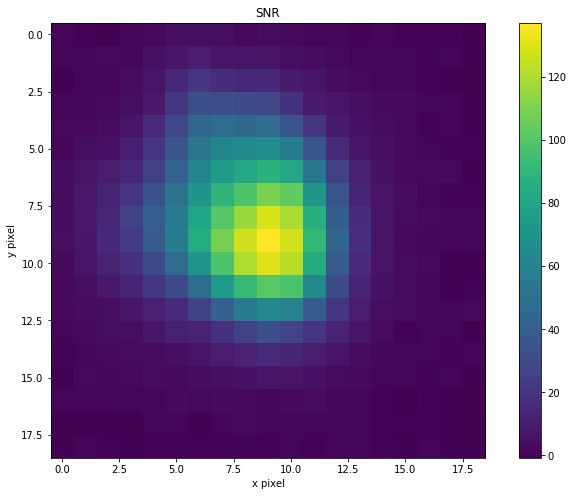

Peak: 1.37e+02, median: 4.07e+00


In [13]:
snr = flux/error

plot_img(snr)
plt.title('SNR')
plt.show()
print("Peak: %2.2e, median: %2.2e" % (np.max(snr), np.median(snr)))

N.B.: These are values **per pixel**; if we want to average them across the square, we must be careful to multiply the RON and the background noise by the number of pixels:

In [18]:
flux_total = np.sum(flux)
error_total = np.sqrt(np.sum(flux) + (1+ron_subfact)*ron**2*flux.size + (1+bkg_subfact)*bkg_noise**2*flux.size)
snr_total = flux_total/error_total

print("Flux: %2.2e+/-%2.2e ph" % (flux_total, error_total))
print("SNR: %2.2e" % snr_total)

Flux: 6.32e+05+/-1.15e+03 ph
SNR: 5.50e+02


> **Your turn now**: use ```ogrid``` to design a circular mask for the target and an annular mask for the background, and use it to perform photometry on SZ Lyn. Compare the SNR you obtain in this case with the one obtained with a square mask.

### Let's talk magnitudes

The photon flux we have just measured is affected by the specific observational conditions (seeing, airmass, etc.). To convert it into a magnitude, the simplest approach is to compare it with the flux of some **reference stars** in the field, whose magnitude is known. We have two such star, AUID 000-BJR-415 and AUID 000-BJR-416: 

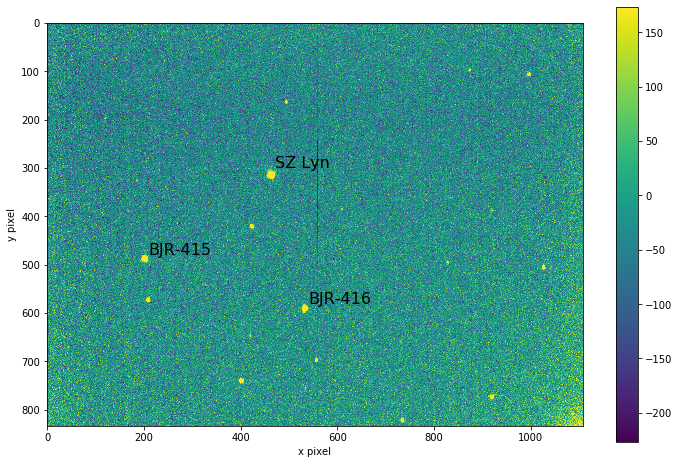

In [15]:
x_ref, y_ref = 202, 487

plot_img_medrange(sci.data)
plt.text(470, 300, 'SZ Lyn', c='black', size=16)
plt.text(210, 480, 'BJR-415', c='black', size=16)
plt.text(540, 580, 'BJR-416', c='black', size=16)
plt.show()

We take the chance to create a ```Star``` object and to refactor the procedure developed into methods of this object (the same class and methods are available in ```utils.py```): 

In [23]:
class Star():
    
    def __init__(self, img, reg):
        self.img = img
        self.reg = reg
        
        self.sub_img = img[reg]
        shape = self.sub_img.shape
        self.xc, self.yc = extrema(self.sub_img)    
        self.rows, self.cols = np.ogrid[-self.yc:shape[0]-self.yc, -self.xc:shape[1]-self.xc]
 
    def photometry(self, gain=0.6, ron=28.8):

        # Mask sub-image
        mask = np.logical_and(np.abs(self.rows)<thr, np.abs(self.cols)<thr)        
        inside = np.copy(self.sub_img)
        outside = np.copy(self.sub_img)
        inside[~mask] = np.nan
        outside[mask] = np.nan
        npix = np.sum(~np.isnan(inside))
    
        # Subtract background
        outside_mean = np.nanmean(outside)
        outside_std = np.nanstd(outside)
        inside_bkgsub = inside-outside_mean
        self.bkg = outside_mean*gain
        self.bkg_noise = outside_std*gain
    
        # Compute flux and error
        self.flux = np.nansum(inside_bkgsub)*gain
        self.error = np.sqrt(self.flux + (1+ron_subfact)*ron**2*npix + (1+bkg_subfact)*self.bkg_noise**2*npix)
        self.snr = self.flux/self.error 

Doing photometry on different stars of choice is now extremely simple:

In [24]:
sz_lyn = Star(sci.data, np.s_[250:380,400:530])
sz_lyn.photometry()

bjr_415 = Star(sci.data, np.s_[420:550,140:270])
bjr_415.photometry()

bjr_416 = Star(sci.data, np.s_[520:650,470:600])
bjr_416.photometry()

print("SZ Lyn  – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (sz_lyn.flux, sz_lyn.error, sz_lyn.bkg, sz_lyn.snr))
print("BJR-415 – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (bjr_415.flux, bjr_415.error, bjr_415.bkg, bjr_415.snr))
print("BJR-416 – Flux: %2.2e+/-%2.2e ph; background: %2.2e ph; SNR: %2.2e" 
      % (bjr_416.flux, bjr_416.error, bjr_416.bkg, bjr_416.snr))

SZ Lyn  – Flux: 6.32e+05+/-1.15e+03 ph; background: -2.13e+01 ph; SNR: 5.50e+02
BJR-415 – Flux: 1.89e+05+/-9.66e+02 ph; background: -1.81e+01 ph; SNR: 1.96e+02
BJR-416 – Flux: 1.17e+05+/-8.91e+02 ph; background: -1.34e+01 ph; SNR: 1.31e+02


The magnitude of our star is then easily computed from the flux and magnitude of the reference (we make this function a method of ```Star``` too). We use AUID 000-BJR-415 as reference and AUID 000-BJR-416 as cross-check:

In [22]:
def magnitude(self, ref):
    self.mag = ref.mag - 2.5*(np.log10(self.flux)-np.log10(ref.flux))

    
Star.magnitude = magnitude
bjr_415.mag = 10.924  # V
sz_lyn.magnitude(bjr_415)
bjr_416.magnitude(bjr_415)


print("SZ Lyn  - Magnitude: %2.3f" % sz_lyn.mag)
print("BJR-416 - Magnitude: %2.3f (expected 11.456)" % bjr_416.mag)

SZ Lyn  - Magnitude: 9.616
BJR-416 - Magnitude: 11.447 (expected 11.456)


> **Your turn now**: perform photometry with a circular mask on all frames in sci_2015/. Estimate the error on magnitude using two reference stars. Save the magnitude values in a FITS frame.